# 机器翻译和数据集


机器翻译（MT）：将一段文本从一种语言自动翻译为另一种语言，用神经网络解决这个问题通常称为神经机器翻译（NMT）。
主要特征：输出是单词序列而不是单个单词。 输出序列的长度可能与源序列的长度不同。

In [9]:
import os
os.listdir('/home/kesci/input/')

['fraeng6506', 'd2l9528', 'jaychou_lyrics4703', 'd2l_jay9460']

In [21]:
import sys
sys.path.append('/home/kesci/input/d2l9528/')
import collections
import d2l
import zipfile
from d2l.data.base import Vocab
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch import optim

### 数据预处理
将数据集清洗、转化为神经网络的输入minbatch

In [22]:
with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()
print(raw_text[0:1000])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)
Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)
Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)
Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)
Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Phoenix)
Stop!	Ça suffit !	CC-BY 2.0 (France) Attribution: tato

In [23]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:1000])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi .	salut !	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)
hi .	salut .	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4320462 (gillux)
run !	cours !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906331 (sacredceltic)
run !	courez !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906332 (sacredceltic)
who?	qui ?	cc-by 2 .0 (france) attribution: tatoeba .org #2083030 (ck) & #4366796 (gillux)
wow !	ça alors !	cc-by 2 .0 (france) attribution: tatoeba .org #52027 (zifre) & #374631 (zmoo)
fire !	au feu !	cc-by 2 .0 (france) attribution: tatoeba .org #1829639 (spamster) & #4627939 (sacredceltic)
help !	à l'aide !	cc-by 2 .0 (france) attribution: tatoeba .org #435084 (lukaszpp) & #128430 (sysko)
jump .	saute .	cc-by 2 .0 (france) attribution: tatoeba .org #631038 (shishir) & #2416938 (phoenix)
stop !	ça suffit !	cc-b

字符在计算机里是以编码的形式存在，我们通常所用的空格是 \x20 ，是在标准ASCII可见字符 0x20~0x7e 范围内。
而 \xa0 属于 latin1 （ISO/IEC_8859-1）中的扩展字符集字符，代表不间断空白符nbsp(non-breaking space)，超出gbk编码范围，是需要去除的特殊字符。在数据预处理的过程中，我们首先需要对数据进行清洗。

### 分词
字符串---单词组成的列表

In [24]:
num_examples = 50000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) >= 2:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))
        
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

In [25]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],label=['source', 'target'])
d2l.plt.legend(loc='upper right');

<Figure size 252x180 with 1 Axes>

### 建立词典
单词组成的列表---单词id组成的列表

In [26]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return d2l.data.base.Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

3789

### 载入数据集

In [27]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))#不足填充
pad(src_vocab[source[0]], 10, src_vocab.pad)

[38, 4, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
def build_array(lines, vocab, max_len, is_source):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(1) #第一个维度
    return array, valid_len

In [29]:
def load_data_nmt(batch_size, max_len): # This function is saved in d2l.
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [30]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, in train_iter:
    print('X =', X.type(torch.int32), '\nValid lengths for X =', X_valid_len,
        '\nY =', Y.type(torch.int32), '\nValid lengths for Y =', Y_valid_len)
    break

X = tensor([[  12,    8,   58,  106,  130,    4,    0,    0],
        [  43, 1072,    4,    0,    0,    0,    0,    0]], dtype=torch.int32) 
Valid lengths for X = tensor([6, 3]) 
Y = tensor([[   1,   15,   14,  175,  151,   88,    4,    2],
        [   1,   16, 4004,    4,    2,    0,    0,    0]], dtype=torch.int32) 
Valid lengths for Y = tensor([8, 5])


# Encoder-Decoder
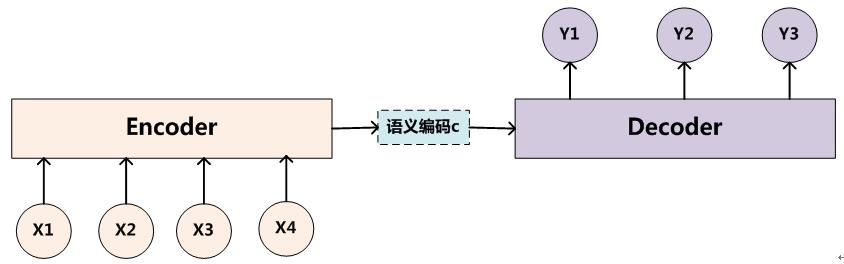

In [31]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [32]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [33]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

可以应用在对话系统、生成式任务中。

# Sequence to Sequence模型
### Encoder
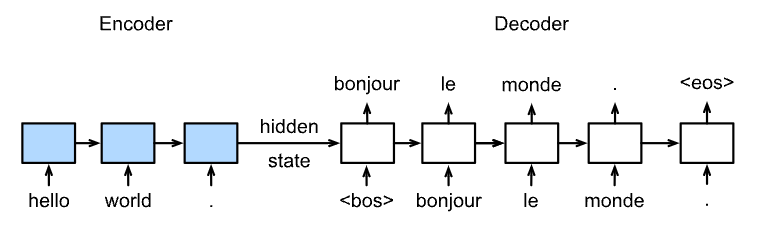
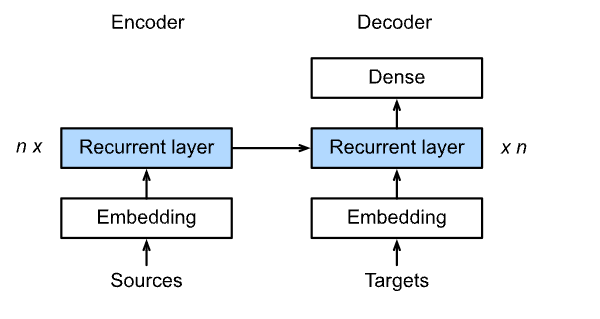
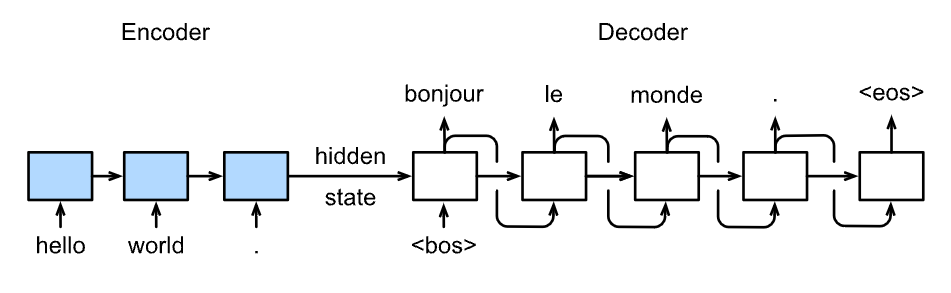

In [34]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.num_layers=num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
   
    def begin_state(self, batch_size, device):
        return [torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device),
                torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device)]
    def forward(self, X, *args):
        X = self.embedding(X) # X shape: (batch_size, seq_len, embed_size)
        X = X.transpose(0, 1)  # RNN needs first axes to be time
        # state = self.begin_state(X.shape[1], device=X.device)
        out, state = self.rnn(X)
        # The shape of out is (seq_len, batch_size, num_hiddens).
        # state contains the hidden state and the memory cell
        # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
        return out, state

In [35]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

# Decoder

In [36]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).transpose(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).transpose(0, 1)
        return out, state

In [37]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

### 损失函数

In [38]:
def SequenceMask(X, X_len,value=0):
    maxlen = X.size(1)
    mask = torch.arange(maxlen)[None, :].to(X_len.device) < X_len[:, None]   
    X[~mask]=value
    return X

In [39]:
X = torch.tensor([[1,2,3], [4,5,6]])
SequenceMask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [40]:
X = torch.ones((2,3, 4))
SequenceMask(X, torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [41]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_length shape: (batch_size, )
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len)
        weights = torch.ones_like(label)
        weights = SequenceMask(weights, valid_length).float()
        self.reduction='none'
        output=super(MaskedSoftmaxCELoss, self).forward(pred.transpose(1,2), label)
        return (output*weights).mean(dim=1)

In [42]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones((3, 4, 10)), torch.ones((3,4),dtype=torch.long), torch.tensor([4,3,0]))

tensor([2.3026, 1.7269, 0.0000])

### 训练

In [45]:
def train_ch7(model, data_iter, lr, num_epochs, device):  # Saved in d2l
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:,:-1], Y[:,1:], Y_vlen-1
            
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen).sum()
            l.backward()

            with torch.no_grad():
                d2l.grad_clipping_nn(model, 5, device)
            num_tokens = Y_vlen.sum().item()
            optimizer.step()
            l_sum += l.sum().item()
            num_tokens_sum += num_tokens
        if epoch % 50 == 0:
            print("epoch {0:4d},loss {1:.3f}, time {2:.1f} sec".format( 
                  epoch, (l_sum/num_tokens_sum), time.time()-tic))
            tic = time.time()

In [46]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_examples, max_len = 64, 1e3, 10
lr, num_epochs, ctx = 0.005, 300, d2l.try_gpu()
src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(
    batch_size, max_len,num_examples)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_ch7(model, train_iter, lr, num_epochs, ctx)

epoch   50,loss 0.122, time 23.3 sec
epoch  100,loss 0.063, time 23.2 sec
epoch  150,loss 0.040, time 24.0 sec
epoch  200,loss 0.031, time 23.5 sec
epoch  250,loss 0.028, time 23.4 sec
epoch  300,loss 0.025, time 23.6 sec


### 测试

In [47]:
def translate_ch7(model, src_sentence, src_vocab, tgt_vocab, max_len, device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.tensor(src_tokens, device=device)
    enc_valid_length = torch.tensor([src_len], device=device)
    # use expand_dim to add the batch_size dimension.
    enc_outputs = model.encoder(enc_X.unsqueeze(dim=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.tensor([tgt_vocab.bos], device=device).unsqueeze(dim=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).int().item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [48]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate_ch7(
        model, sentence, src_vocab, tgt_vocab, max_len, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !
